# Imports

In [61]:
from collections import defaultdict
import pandas as pd
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import ntpath 
import sys
from datetime import timedelta
import datetime as dt
from matplotlib import pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)

import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent

import ray
import sys  
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../')
from utils import *
import utils
DTYPES = get_dataTypes()
DATAROOT = utils.DATAROOT


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

# MS_IN_ONE_SEC = 1000
# SEC_IN_ONE_MIN = 60
# MIN_IN_ONE_HOUR = 60
# HOUR_IN_ONE_DAY = 24

# MS_IN_ONE_MIN = MS_IN_ONE_SEC* SEC_IN_ONE_MIN 
# MS_IN_ONE_DAY = HOUR_IN_ONE_DAY*MIN_IN_ONE_HOUR*SEC_IN_ONE_MIN*MS_IN_ONE_SEC # day    = 24 hours x 60 minutes x 60 seconds x 1000 milliseconds

# def extract_pcode(fn):
#     bname = ntpath.basename(fn)
#     return bname[:bname.find('_')]


# Subjective labels 
- our ground truth is the perceived-disturbance level obtained through self-reported ESM
- data is collected in 3 groups 
    - \[April 30 ~ May 6\]
    - \[May 7    ~ May 14\]
    - \[May 15   ~ May 23\]
- owing to varying number of reponses for the given participant, #ESM responses vary across participants 

# less engaged participants

Text(0, 0.5, 'CDF')

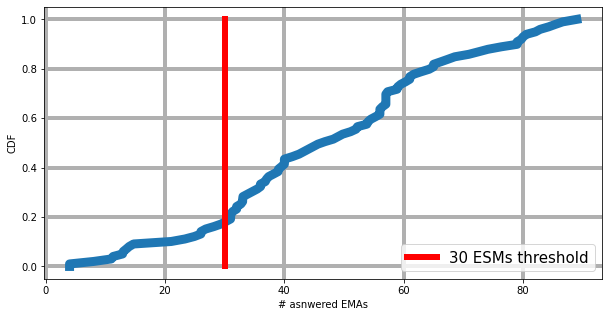

In [11]:
MIN_INTERVENTIONS_THRESHOLD = 30

ds = pd.read_csv(
    join(DATAROOT,'esm_data.csv')
    , usecols=['pcode','responseTimestamp']    
).groupby('pcode').count()['responseTimestamp'].sort_values()
I = np.linspace(0,1,100)

fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(10,5))
plt.plot(ds.quantile(I),I,linewidth=9,)
#plt.plot([56, 56],[0,1], linewidth=6,color='red',label='50% of expected ESMs threshold')

plt.plot(
    [MIN_INTERVENTIONS_THRESHOLD,MIN_INTERVENTIONS_THRESHOLD],[0,1]
    ,linewidth=6, color='red',label='30 ESMs threshold'
)
plt.legend(fontsize=15)
plt.grid(True,linewidth=4)
plt.xlabel('# asnwered EMAs')
plt.ylabel('CDF')

# Clean ESM
- exclude esm
    - if esm is not withing data collection period
    - if no associated Sensor data
    - if the record is corrupted: negative response delay
    - if the record is a duplicate ['pid','timestamp']

In [65]:
def pid2campainname(pcode):     
    if pcode.startswith('30'):
        return 'april30'
    elif pcode.startswith('7'):
        return 'may7'
    elif pcode.startswith('15'):
        return 'may15'

campains = pd.DataFrame({
        'name' : ['april30', 'may7', 'may15']
        ,'start': pd.to_datetime([
             '2019-4-30 10:00'
            ,'2019-5-08 10:00'
            ,'2019-5-16 10:00'
        ]) 
}).set_index('name')
campains['end'] = campains.start+ timedelta(days=6, hours=12)
campains

,start,end
name,,
april30,2019-04-30 10:00:00,2019-05-06 22:00:00
may7,2019-05-08 10:00:00,2019-05-14 22:00:00
may15,2019-05-16 10:00:00,2019-05-22 22:00:00


In [66]:
def within_collection_period(record):
    campaign = campains.loc[pid2campainname(record.pid)]
    return (record.timestamp >= campaign.start) \
                & (record.timestamp <=campaign.end)


def exclude_esm_in_non_collection_period(esm):
    return esm[esm.apply(lambda x: within_collection_period(x), axis=1)]


def process_csv_file(fn, esm):
        df_=pd.read_csv(
            fn,usecols=['timestamp'], dtype={'timestamp':int}             
        )
        df_.timestamp = pd.to_datetime(
            df_.timestamp.values, unit='ms', utc=True
        ).tz_convert(TZ).tz_localize(None)

        s, e = df_['timestamp'].min(), df_['timestamp'].max()        
        
        # esm data can be analyzed only if it has associated sensor data in the last 12 HR 
        M = (esm['pid']==extract_pcode(fn)) & \
            (esm.timestamp >=s) &\
            (esm.timestamp <=(e+timedelta(hours=12)))
        return esm[M]


# if given ESM has no sensor data, then there is no point analyszing the ESM
def exclude_esm_without_sensor_data(esm):
    func = ray.remote(process_csv_file).remote
    results = [func(fn,esm) for fn in (glob(join(DATAROOT,'aggregated_csv','*')))]
    return pd.concat(
        ray.get(results)
    )

In [64]:

esm = pd.read_csv(
    join(DATAROOT,'esm_data.csv')
    , dtype={
        'pcode':str,'valence':float, 'arousal':float, 'attention':float, 'stress':float,
        'duration':float, 'disturbance':float, 'change':float 
    }
    , parse_dates=['responseTime']
).rename(columns={'pcode':'pid'})     

esm['timestamp'] = pd.to_datetime(
    esm['responseTimestamp'], unit='ms', utc=True
).dt.tz_convert(TZ).dt.tz_localize(None)

cleaning_info = pd.DataFrame({'Step Description':'Original data', '#participants':esm.pid.nunique(), '#responses':len(esm)},index=[0])

esm = exclude_esm_in_non_collection_period(esm)
cleaning_info = cleaning_info.append({'Step Description':'Exclude ESM if not within campaign period', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

with on_ray(num_cpus=20):
    esm = exclude_esm_without_sensor_data(esm)
cleaning_info = cleaning_info.append(
    {'Step Description':'Exclude ESM if no associated sensor data', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

esm['response_delay'] = (esm['responseTimestamp'] - esm['scheduledTimestamp'])/utils.MS_IN_ONE_MIN
esm = esm[esm['response_delay']>=0]
cleaning_info = cleaning_info.append(
    {'Step Description':'Exclude ESM if timestamp is currupted', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

esm = esm.drop_duplicates(subset=['pid','timestamp'])
cleaning_info = cleaning_info.append(
    {'Step Description':'After excluding duplicate data', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

ds = esm[['disturbance','pid']].groupby('pid').std()['disturbance']
zero_varience_pids = ds[ds==0].index.to_list()  
esm = esm[~esm.pid.isin(zero_varience_pids)]
cleaning_info = cleaning_info.append(
    {'Step Description':'After excluding participants with zero variance in their responses', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

# MIN_INTERVENTIONS_THRESHOLD = 30 # max is 112 ESMs
# ds = esm.groupby('pid').size().sort_values()
# pids_with_enough_esm = ds[ds>MIN_INTERVENTIONS_THRESHOLD].index.to_list()
# esm = esm[esm.pid.isin(pids_with_enough_esm)]
# cleaning_info = cleaning_info.append(
#     {'Step Description':'After excluding participants with less than 30 ESM responses', '#participants':esm.pid.nunique(), '#responses':len(esm)}
#     ,ignore_index=True
# )
esm = esm[~esm.pid.isin(['3008'])] # this participant only has smartphone or smartwatch data
cleaning_info = cleaning_info.append(
    {'Step Description':'After excluding participants with most sensor sources missing', '#participants':esm.pid.nunique(), '#responses':len(esm)}
    ,ignore_index=True
)

clean_esm_file = join(DATAROOT,'cleaned_esm_data.csv')
esm.to_csv(clean_esm_file, index=False)

cleaning_info.to_csv('GT_cleaning_info.csv', index=False)
cleaning_info

,Step Description,#participants,#responses
0,Original data,79,3715
1,Exclude ESM if not within campaign period,79,3592
2,Exclude ESM if no associated sensor data,77,3543
3,Exclude ESM if timestamp is currupted,77,3537
4,After excluding duplicate data,77,3426
5,After excluding participants with zero varianc...,74,3401
6,After excluding participants with most sensor ...,73,3334


# Visualize ESM responses

100%|██████████| 59/59 [00:00<00:00, 22655.31it/s]


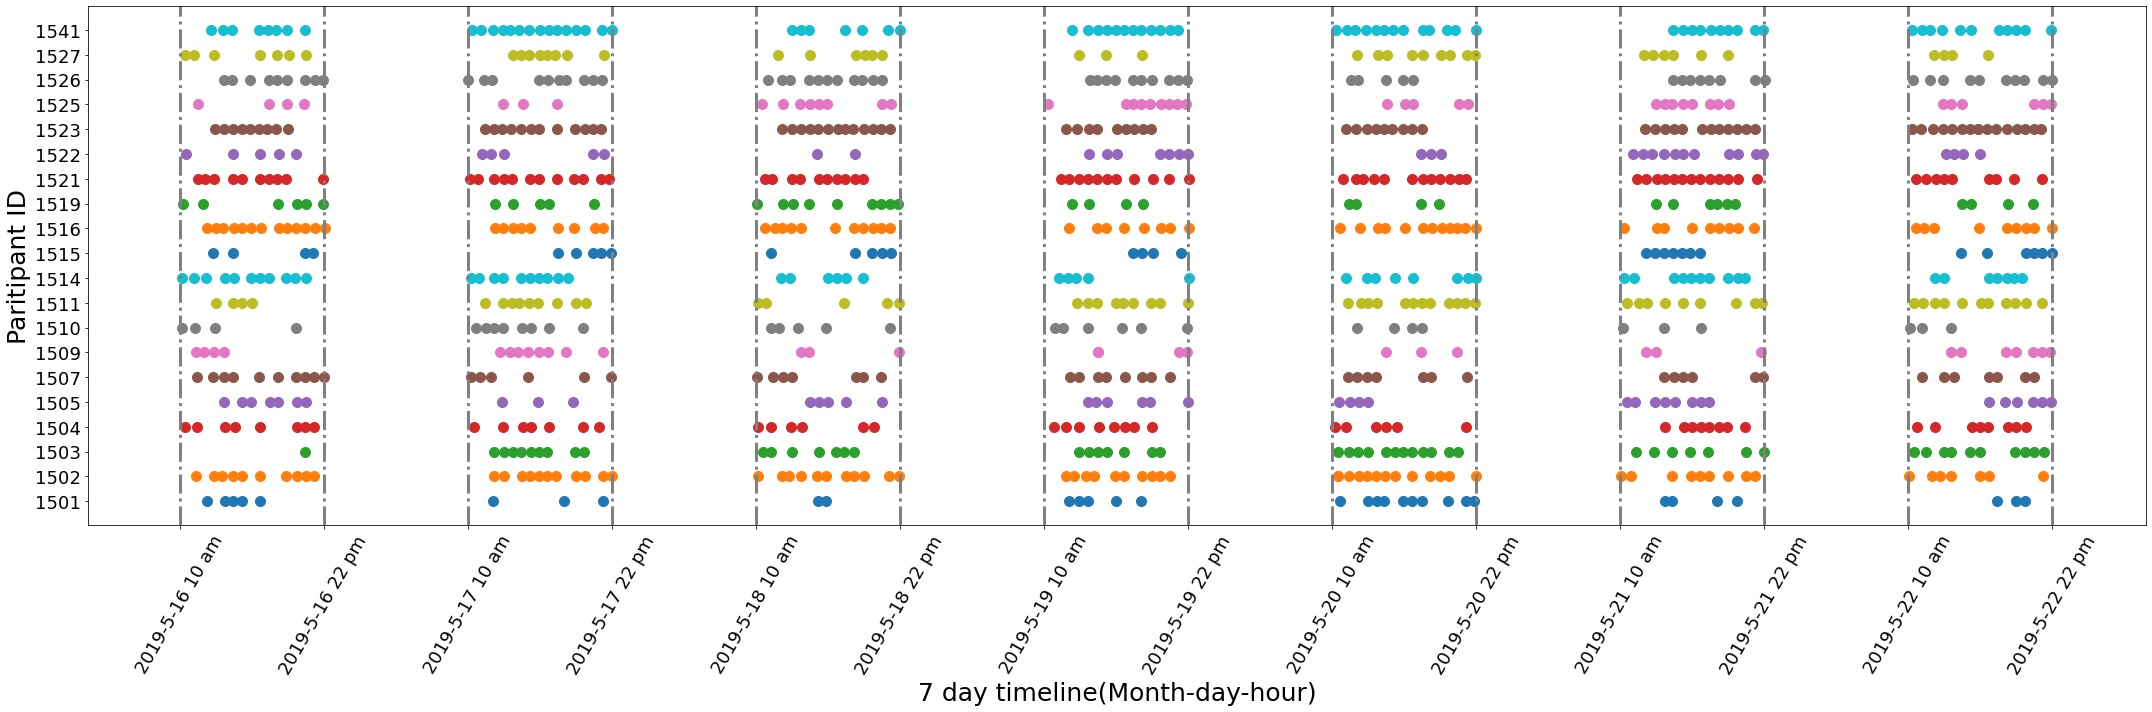

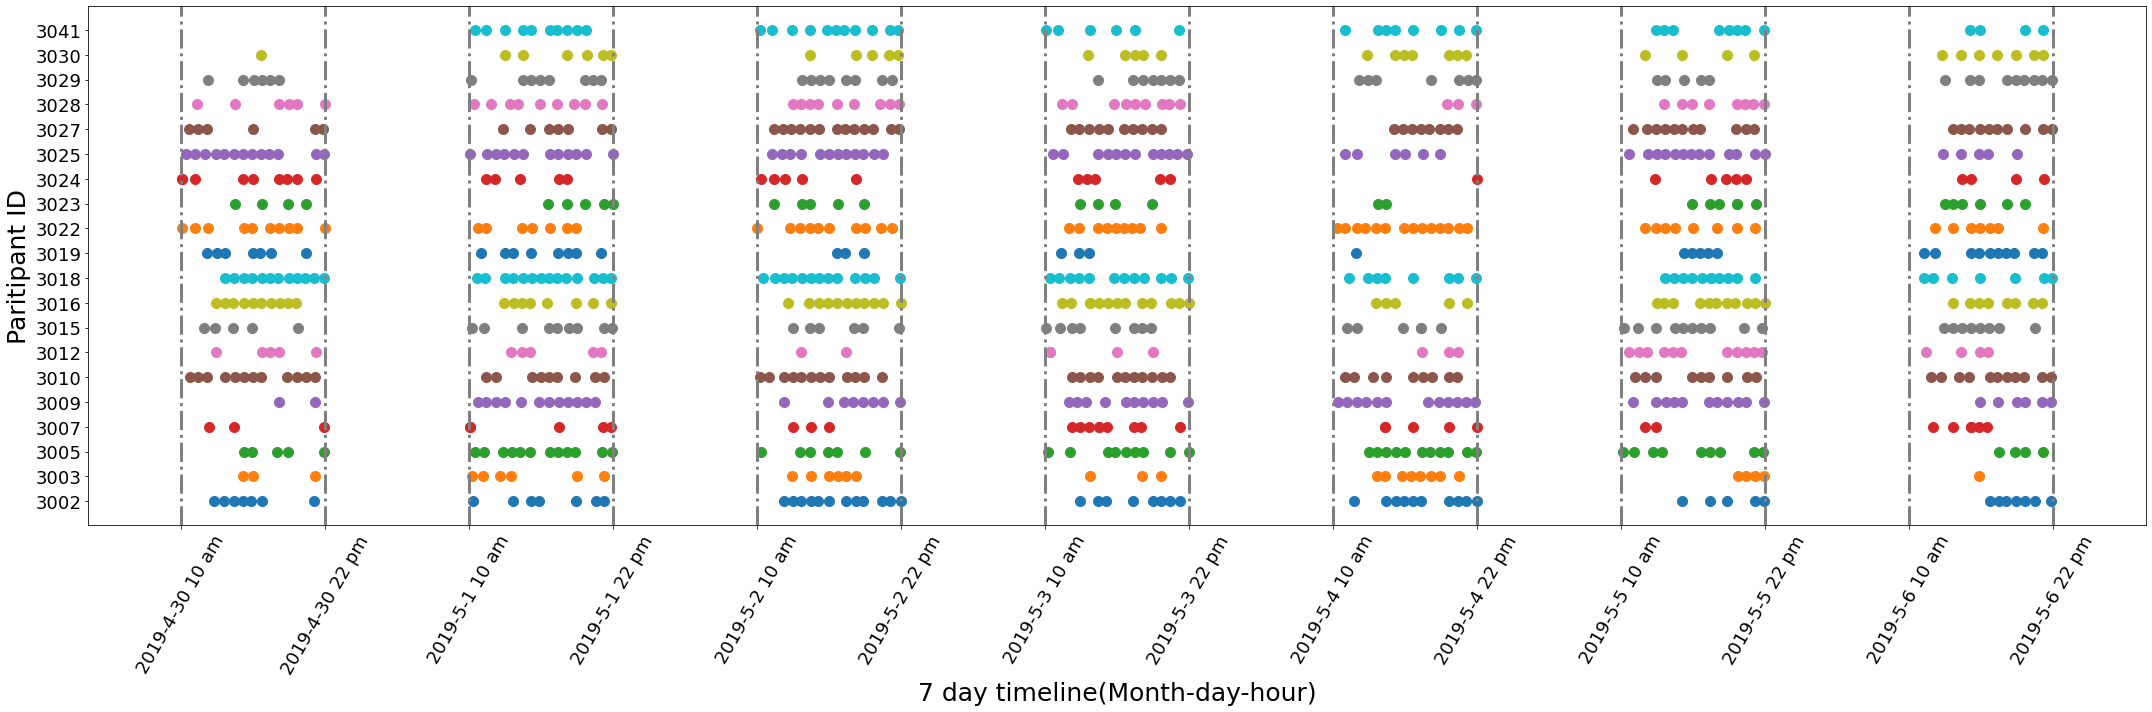

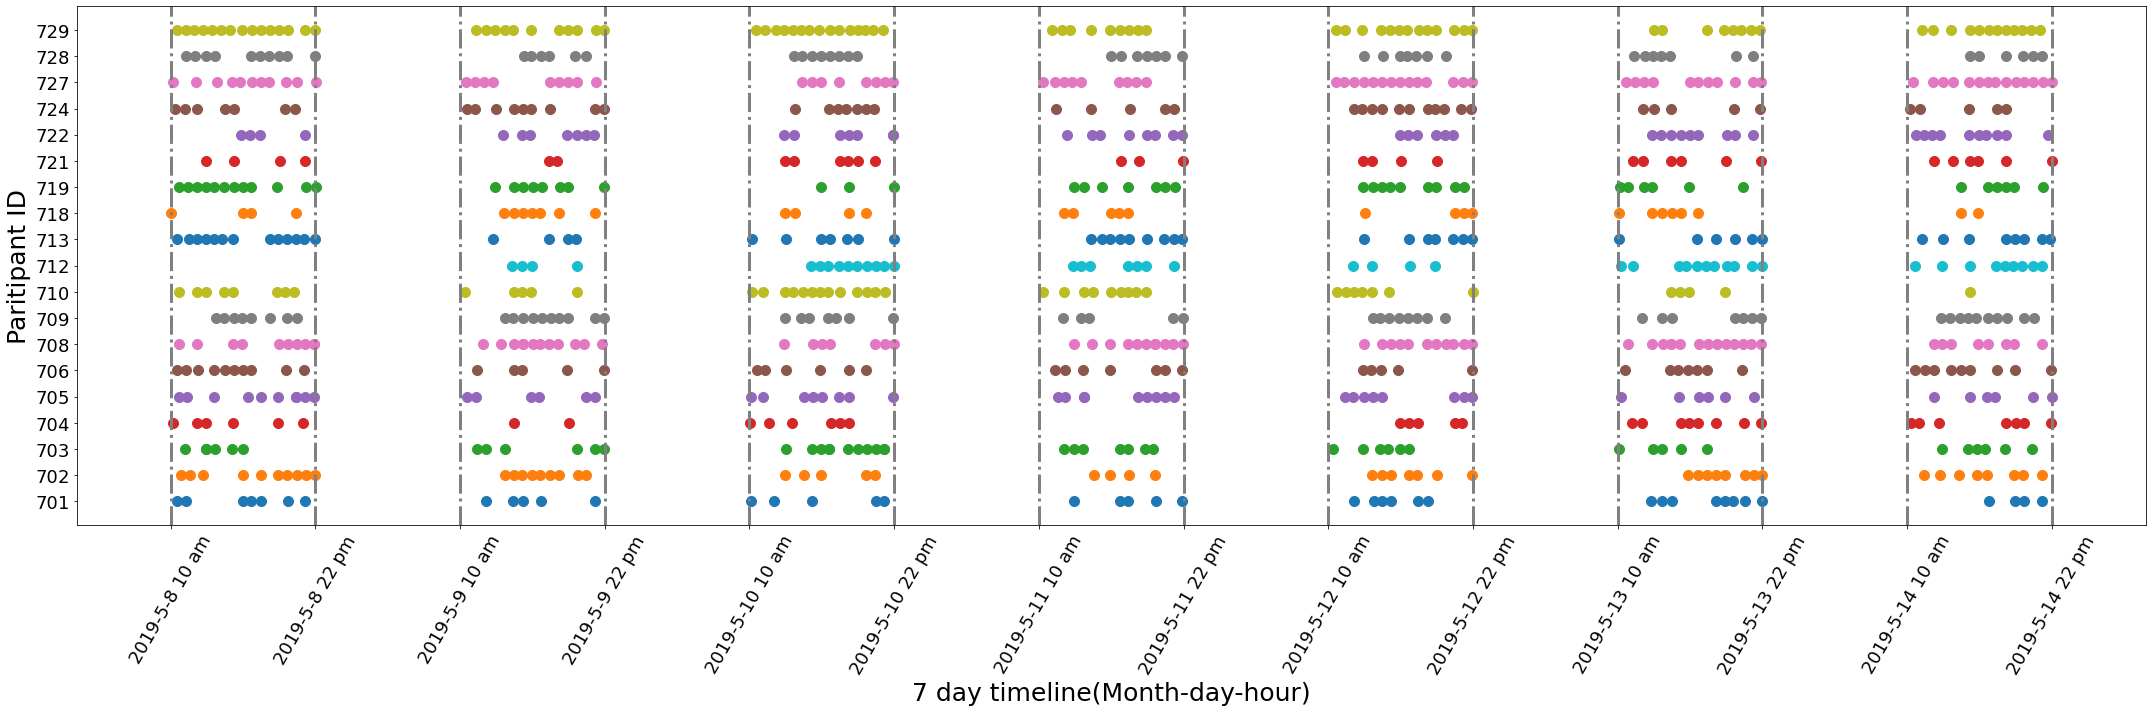

In [18]:
def split_into_groups(df):
    # for each campain make a list of tuples (pid, df)
    groups = defaultdict(list)
    for pid, frame in tqdm(df.groupby('pid')):
        groupname = pid2campainname(pid)
        groups[groupname].append((pid, frame))
    return groups
    
   
def put_x_ticks(plt, groupname='april30'):        
    
    start_times_dt = [campains.loc[groupname].start + timedelta(hours=24*i) for i in range(7) ]
    end_times_dt = [s + timedelta(hours=12) for s in start_times_dt ]
    
    df = pd.DataFrame({'timeline':start_times_dt+end_times_dt})        
    df['prettified_dt'] = df['timeline'].apply( 
        lambda x: '{}-{}-{} {} {}'.format(x.year, x.month,x.day,x.hour, 'am' if x.hour==10 else 'pm')
    )
    
    plt.xticks(df['timeline'],df['prettified_dt'], rotation = 60)
    
    
def plot_participant_group(g,groupname):
    plt.figure(figsize=(30,10))
    pids = []
    
    for i, (pid, frame) in enumerate(g):
        pids.append(pid)                
        plt.scatter(frame.index, np.ones(frame.shape[0],)*i+1, s=100 )
        
    plt.ylabel('Paritipant ID')
    plt.xlabel('7 day timeline(Month-day-hour)')        
    
    put_x_ticks(plt, groupname=groupname)
    plt.yticks(np.arange(len(g))+1,pids)

    plt.grid(True,linewidth=3,color='grey', axis='x', linestyle='-.')    
    plt.tight_layout()
    

plt.rc('axes', labelsize=25) #fontsize of the x and y labels
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)


labels = pd.read_csv(
    clean_esm_file, dtype={'pid':str}
    , parse_dates=['timestamp']
).set_index(['timestamp'])

groups = split_into_groups(labels)
for groupname in groups.keys():
     plot_participant_group(groups[groupname], groupname=groupname)

# Binning

In [102]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(join(DATAROOT,'cleaned_esm_data.csv'), 
 dtype=LABEL_DTYPES,
                     parse_dates=['timestamp'])

labels.set_index(['pid','timestamp'], inplace=True)
labels.head()

responseTime  responseTimestamp  \
pid timestamp                                                           
718 2019-05-08 10:00:36  2019-05-08 10:00:36+09:00      1557277236000   
    2019-05-08 15:59:55  2019-05-08 15:59:55+09:00      1557298795000   
    2019-05-08 16:42:24  2019-05-08 16:42:24+09:00      1557301344000   
    2019-05-08 20:25:33  2019-05-08 20:25:33+09:00      1557314733000   
    2019-05-09 13:40:32  2019-05-09 13:40:32+09:00      1557376832000   

                                         scheduledTime  scheduledTimestamp  \
pid timestamp                                                                
718 2019-05-08 10:00:36  2019-05-08T10:00:00.000+09:00       1557277200000   
    2019-05-08 15:59:55  2019-05-08T15:56:00.000+09:00       1557298560000   
    2019-05-08 16:42:24  2019-05-08T16:42:00.000+09:00       1557301320000   
    2019-05-08 20:25:33  2019-05-08T20:25:00.000+09:00       1557314700000   
    2019-05-09 13:40:32  2019-05-09T13:40:00.000+09:00       1557376800000   

                         valence  arousal  attention  stress  duration  \
pid timestamp                                                            
718 2019-05-08 10:00:36      1.0      0.0        2.0    -2.0      30.0   
    2019-05-08 15:59:55      3.0      3.0        3.0    -3.0      60.0   
    2019-05-08 16:42:24      0.0     -1.0       -2.0     1.0      30.0   
    2019-05-08 20:25:33      2.0      2.0        3.0    -1.0      30.0   
    2019-05-09 13:40:32      1.0     -2.0        1.0     1.0      30.0   

                         disturbance  change  openness  conscientiousness  \
pid timestamp                                                               
718 2019-05-08 10:00:36          1.0    -2.0      13.0               12.0   
    2019-05-08 15:59:55         -3.0    -1.0      13.0               12.0   
    2019-05-08 16:42:24         -1.0     0.0      13.0               12.0   
    2019-05-08 20:25:33          2.0    -1.0      13.0               12.0   
    2019-05-09 13:40:32          2.0    -1.0      13.0               12.0   

                         neuroticism  extraversion  agreeableness   age  \
pid timestamp                                                             
718 2019-05-08 10:00:36          7.0          12.0           12.0  22.0   
    2019-05-08 15:59:55          7.0          12.0           12.0  22.0   
    2019-05-08 16:42:24          7.0          12.0           12.0  22.0   
    2019-05-08 20:25:33          7.0          12.0           12.0  22.0   
    2019-05-09 13:40:32          7.0          12.0           12.0  22.0   

                        gender  response_delay  
pid timestamp                                   
718 2019-05-08 10:00:36      F        0.600000  
    2019-05-08 15:59:55      F        3.916667  
    2019-05-08 16:42:24      F        0.400000  
    2019-05-08 20:25:33      F        0.550000  
    2019-05-09 13:40:32      F        0.533333

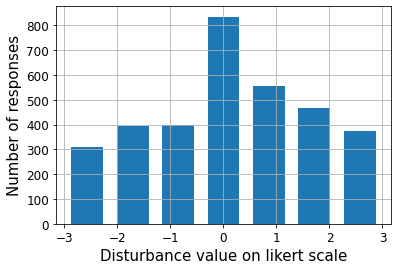

In [103]:
labels.disturbance.hist(bins=7, rwidth=0.7)
plt.xlabel('Disturbance value on likert scale')
plt.ylabel('Number of responses')
plt.grid(True)

receptive        1938
non-receptive    1396
Name: receptivity, dtype: int64


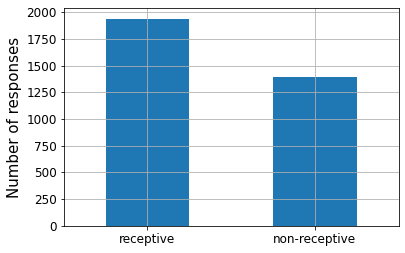

In [104]:
labels['receptivity'] = np.where(labels.disturbance>0, 'non-receptive','receptive')
print(labels.receptivity.value_counts())
labels.receptivity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('Number of responses')
plt.grid()

In [106]:
binned_esm_file = join(DATAROOT,'binned_esm_data.csv')
labels.to_csv(binned_esm_file)


# ESM cleaning with missing sensor data 

## entities / sensor sources

In [63]:
sample_fn = join(DATAROOT,'aggregated_csv','3028_3409214.csv') # 3028 is the participant who has all columns
df_ = pd.read_csv(sample_fn,nrows=1)

# exc 
not_analyzed_sources = ['AppUsageStatEntity', 'RecordEntity'] 
'''
MessageEntity 
- according to EDA, some people have only 1 message per day which makes the MessageEntity source suspicious
- additionally, people mostly use kakao (app) for messaging
'''

M = np.zeros_like(df_.columns, dtype=bool)
for s in not_analyzed_sources:
    M=M|df_.columns.str.startswith(s)

COLUMNS= df_.loc[:,~M].columns

SPHN_SOURCES = list(set([c[:c.find('-')] for c in COLUMNS if 'Entity' in c and c!='timestamp']))
SW_SOURCES = list(set([c[:c.find('-')] for c in COLUMNS if 'Entity' not in c and c!='timestamp']))

print(f"Total #columns: {len(COLUMNS)}")
print(f"Total #smartphone Entities: {len(SPHN_SOURCES)}")
print(f"Total # Smartwatch sensors: {len(SW_SOURCES)}")

Total #columns: 63
Total #smartphone Entities: 12
Total # Smartwatch sensors: 10


In [50]:
SW_SOURCES

['Gsr',
 'AmbientLight',
 'RRInterval',
 'Distance',
 'Calories',
 'Pedometer',
 'UV',
 'HeartRate',
 'SkinTemperature',
 'Accelerometer']

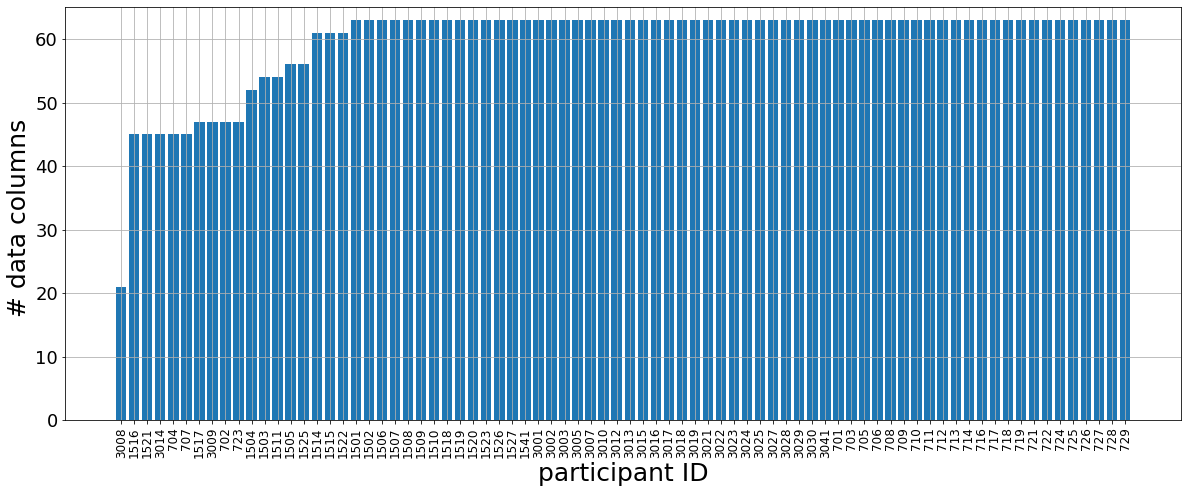

In [20]:
num_columns = []
PIDs = []
column_names_count = defaultdict(lambda: 0)

for fn in sorted(glob(join(DATAROOT,'aggregated_csv','*'))):
    pcols = pd.read_csv(fn,nrows=1).columns
    for c in pcols.tolist():
        column_names_count[c]+=1
        
    num_columns.append(pcols.isin(COLUMNS).sum())
    PIDs.append(extract_pcode(fn))

df_ = pd.DataFrame({'pid':PIDs,'num_cols':num_columns})
df_ = df_.sort_values(['num_cols','pid'])

plt.figure(figsize=(20,76/10))
plt.bar(np.arange(len(df_)),df_['num_cols'])
plt.xticks(np.arange(len(df_)), df_['pid'], rotation=90, fontsize=12)
plt.ylim([0,65])
plt.xlabel('participant ID')
plt.ylabel('# data columns ')
# plt.tight_layout()
plt.grid(True)


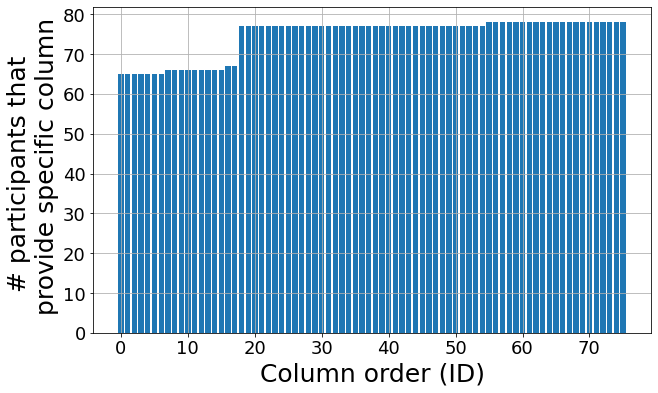

In [23]:
df = pd.DataFrame(column_names_count.items())
plt.figure(figsize=(10,6))
plt.bar(np.arange(df.shape[0]),df.sort_values(1)[1])
#plt.xticks(np.arange(df.shape[0]), COLUMNS , rotation=90, fontsize=12)

plt.xlabel('Column order (ID)')
plt.ylabel('# participants that \n provide specific column')
plt.grid(True)

# Response Delay and Self reported disturbance

Text(0.5, 0, 'Response delay (min.)')

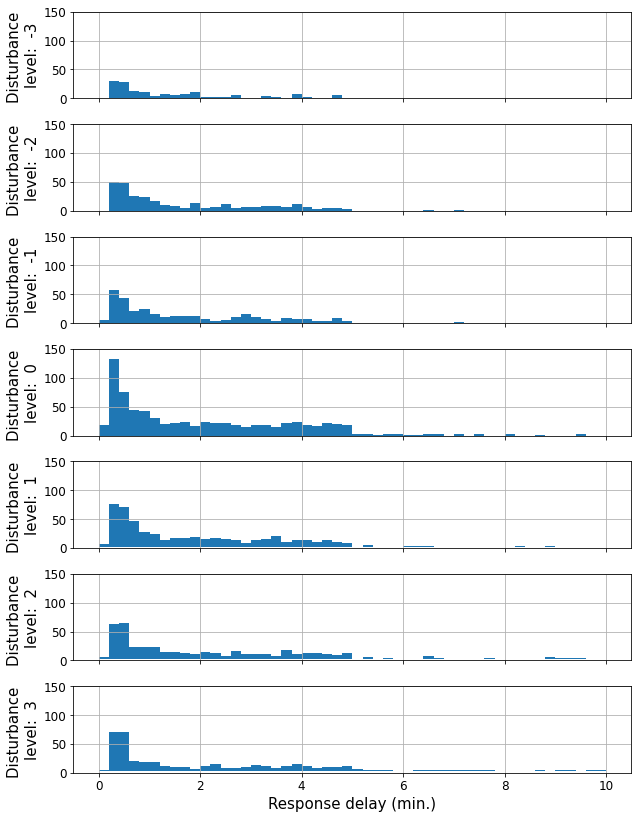

In [24]:
labels = pd.read_csv(
    clean_esm_file, dtype={'pid':str, 'response_delay':float}
    , parse_dates=['timestamp']
).set_index(['timestamp'])

plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('axes', labelsize=15)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
LIKERT_SCALES=7
LIKERT_RANGE = [-3,-2,-1,0,1,2,3]
fig, axes = plt.subplots(nrows=LIKERT_SCALES,ncols=1, figsize=(10,14), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3)
for i,lev in enumerate(LIKERT_RANGE):
    df_ = labels[labels.disturbance==lev]
    
    df_['response_delay'].hist(ax=axes[i], y=lev, bins=50, range=[0,10])
    axes[i].set_ylabel(f'Disturbance \nlevel:  {lev}')
    axes[i].set_ylim([0,150])
plt.xlabel('Response delay (min.)')
#plt.ylabel('Self reported Receptivity\n')


Text(0.5, 0, 'Response delay (min.)')

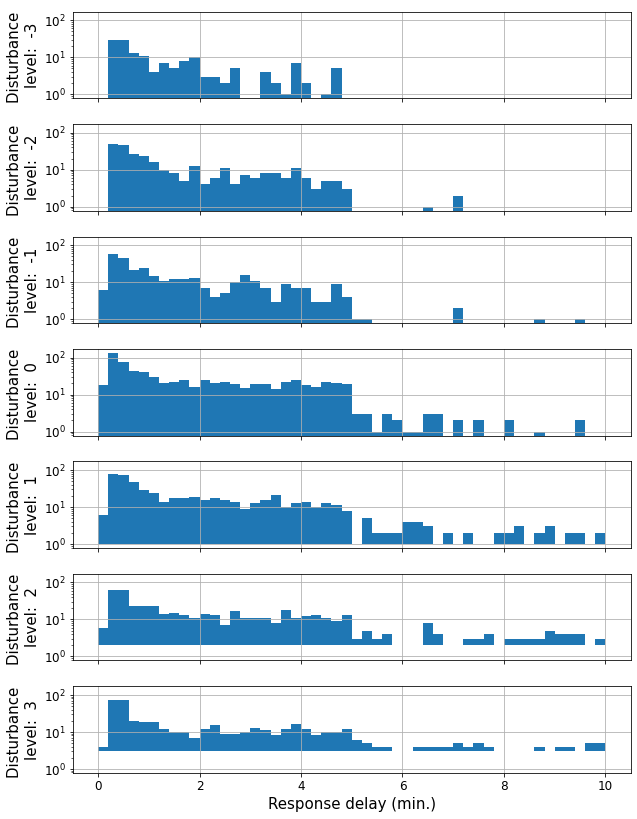

In [25]:
plt.rc('axes', labelsize=15) #fontsize of the x and y labels
plt.rc('axes', labelsize=15)
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)

fig, axes = plt.subplots(nrows=LIKERT_SCALES,ncols=1, figsize=(10,14), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3)
for i,lev in enumerate(LIKERT_RANGE):
    df_ = labels[labels.disturbance==lev]
    df_['response_delay'].hist(ax=axes[i], y=lev, bins=50, range=[0,10])
    axes[i].set_ylabel(f'Disturbance \nlevel:  {lev}')
    #axes[i].set_ylim([0,150])
    axes[i].set_yscale('log')
plt.xlabel('Response delay (min.)')
#plt.ylabel('Self reported Receptivity\n')


In [16]:
labels[['response_delay','disturbance']].corr()

,response_delay,disturbance
response_delay,1.000000,-0.026719
disturbance,-0.026719,1.000000


# Frequency Plots

In [29]:
from time import time

def cnt_participant_source(fn, source):    
    pid = extract_pcode(fn)    
    freq = pd.DataFrame({
        'days':np.arange(1,8,1)
        ,'cnt':np.zeros(7)
    }).assign(
        pid = pid,
        data_type = source,
    ).set_index(['days'])

    try:
        cols = [COLUMNS[COLUMNS.str.contains(source)][0],'timestamp'] # e.g., ['Accelerometer-Y', 'timestamp']
        df_source_ = pd.read_csv(fn
            , dtype=DTYPES
            , usecols=cols
        ).dropna()

        df_source_.timestamp =  pd.to_datetime(
            df_source_.timestamp.values, unit='ms', utc=True
        ).tz_convert(TZ).tz_localize(None) 

    except Exception as e:
        print(f"No {source} for {fn}")
        return freq

    campaign_start_time = campains.loc[pid2campainname(pid)].start
    df_source_=df_source_[df_source_.timestamp>=campaign_start_time]
    days = pd.Series(df_source_.timestamp - campaign_start_time).dt.days+1
    df_source_ = df_source_.assign(
        days = days,
        id = np.arange(len(df_source_))
    )

    for dayname, sensor_reading_cnt in df_source_.days.value_counts().items():        
        freq.at[dayname,'cnt']+=sensor_reading_cnt
    return freq

def cnt4source(source):
    func = ray.remote(cnt_participant_source).remote 
    results_for_source = [ func(fn, source) for fn  in sorted(glob(join(DATAROOT,'aggregated_csv','*')))]
    return pd.concat(ray.get(results_for_source))
    

def get_cnt_data():
    results = []
    for source in tqdm(SPHN_SOURCES+SW_SOURCES):      
        print(f"---counting {source}--")
        results.append(cnt4source( source))        
        
    return pd.concat(results).reset_index()

with on_ray(num_cpus=20):
        CNT_DATA_ = get_cnt_data() # 6min for smartphone sources


  0%|          | 0/22 [00:00<?, ?it/s]

---counting DeviceEventEntity--
(cnt_participant_source pid=106978) No DeviceEventEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


  5%|▍         | 1/22 [01:24<29:29, 84.24s/it]

---counting WifiEntity--
(cnt_participant_source pid=106993) No WifiEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


  9%|▉         | 2/22 [02:46<27:37, 82.87s/it]

---counting DataTrafficEntity--
(cnt_participant_source pid=106982) No DataTrafficEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 14%|█▎        | 3/22 [04:06<25:49, 81.54s/it]

---counting AppUsageEventEntity--
(cnt_participant_source pid=106981) No AppUsageEventEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 18%|█▊        | 4/22 [05:26<24:21, 81.20s/it]

---counting PhysicalActivityTransitionEntity--
(cnt_participant_source pid=106979) No PhysicalActivityTransitionEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 23%|██▎       | 5/22 [06:48<23:02, 81.32s/it]

---counting MessageEntity--
(cnt_participant_source pid=106982) No MessageEntity for ../data/kemphone/aggregated_csv/1505_3704889.csv
(cnt_participant_source pid=106981) No MessageEntity for ../data/kemphone/aggregated_csv/1521_4937642.csv
(cnt_participant_source pid=106986) No MessageEntity for ../data/kemphone/aggregated_csv/1503_3916575.csv
(cnt_participant_source pid=106986) No MessageEntity for ../data/kemphone/aggregated_csv/1525_5399487.csv
(cnt_participant_source pid=106991) No MessageEntity for ../data/kemphone/aggregated_csv/1517_2613190.csv
(cnt_participant_source pid=106987) No MessageEntity for ../data/kemphone/aggregated_csv/1516_5899493.csv
(cnt_participant_source pid=106981) No MessageEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv
(cnt_participant_source pid=106981) No MessageEntity for ../data/kemphone/aggregated_csv/3009_3028255.csv
(cnt_participant_source pid=106990) No MessageEntity for ../data/kemphone/aggregated_csv/3014_639905.csv
(cnt_participant_so

 27%|██▋       | 6/22 [07:59<20:44, 77.79s/it]

---counting PhysicalActivityEventEntity--
(cnt_participant_source pid=106978) No PhysicalActivityEventEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 32%|███▏      | 7/22 [09:21<19:47, 79.20s/it]

---counting BatteryEntity--
(cnt_participant_source pid=106983) No BatteryEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 36%|███▋      | 8/22 [10:40<18:26, 79.04s/it]

---counting CallLogEntity--
(cnt_participant_source pid=106977) No CallLogEntity for ../data/kemphone/aggregated_csv/1517_2613190.csv
(cnt_participant_source pid=106982) No CallLogEntity for ../data/kemphone/aggregated_csv/1511_5809360.csv
(cnt_participant_source pid=106983) No CallLogEntity for ../data/kemphone/aggregated_csv/1504_4833090.csv
(cnt_participant_source pid=106976) No CallLogEntity for ../data/kemphone/aggregated_csv/1516_5899493.csv
(cnt_participant_source pid=106991) No CallLogEntity for ../data/kemphone/aggregated_csv/1521_4937642.csv
(cnt_participant_source pid=106990) No CallLogEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv
(cnt_participant_source pid=106990) No CallLogEntity for ../data/kemphone/aggregated_csv/3009_3028255.csv
(cnt_participant_source pid=106993) No CallLogEntity for ../data/kemphone/aggregated_csv/3014_639905.csv
(cnt_participant_source pid=106979) No CallLogEntity for ../data/kemphone/aggregated_csv/702_4349792.csv
(cnt_participant_sou

 41%|████      | 9/22 [11:48<16:25, 75.81s/it]

---counting ConnectivityEntity--
(cnt_participant_source pid=106990) No ConnectivityEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 45%|████▌     | 10/22 [13:08<15:24, 77.05s/it]

---counting LocationEntity--
(cnt_participant_source pid=106980) No LocationEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv


 50%|█████     | 11/22 [14:27<14:14, 77.65s/it]

---counting MediaEntity--
(cnt_participant_source pid=106994) No MediaEntity for ../data/kemphone/aggregated_csv/1516_5899493.csv
(cnt_participant_source pid=106975) No MediaEntity for ../data/kemphone/aggregated_csv/1522_4460834.csv
(cnt_participant_source pid=106993) No MediaEntity for ../data/kemphone/aggregated_csv/1504_4833090.csv
(cnt_participant_source pid=106979) No MediaEntity for ../data/kemphone/aggregated_csv/1521_4937642.csv
(cnt_participant_source pid=106985) No MediaEntity for ../data/kemphone/aggregated_csv/1503_3916575.csv
(cnt_participant_source pid=106987) No MediaEntity for ../data/kemphone/aggregated_csv/1515_3825656.csv
(cnt_participant_source pid=106988) No MediaEntity for ../data/kemphone/aggregated_csv/1514_3851083.csv
(cnt_participant_source pid=106982) No MediaEntity for ../data/kemphone/aggregated_csv/3008_4644467.csv
(cnt_participant_source pid=106976) No MediaEntity for ../data/kemphone/aggregated_csv/3014_639905.csv
(cnt_participant_source pid=106986) No 

 55%|█████▍    | 12/22 [15:38<12:37, 75.75s/it]

---counting Gsr--


 59%|█████▉    | 13/22 [17:03<11:45, 78.35s/it]

---counting AmbientLight--


 64%|██████▎   | 14/22 [18:26<10:38, 79.77s/it]

---counting RRInterval--


 68%|██████▊   | 15/22 [19:48<09:23, 80.55s/it]

---counting Distance--


 73%|███████▎  | 16/22 [21:12<08:09, 81.66s/it]

---counting Calories--


 77%|███████▋  | 17/22 [22:35<06:49, 81.95s/it]

---counting Pedometer--


 82%|████████▏ | 18/22 [23:57<05:27, 81.88s/it]

---counting UV--


 86%|████████▋ | 19/22 [25:18<04:05, 81.71s/it]

---counting HeartRate--


 91%|█████████ | 20/22 [26:42<02:44, 82.24s/it]

---counting SkinTemperature--


 95%|█████████▌| 21/22 [28:03<01:21, 81.95s/it]

---counting Accelerometer--


100%|██████████| 22/22 [29:31<00:00, 80.51s/it]


In [32]:
CNT_DATA_['cnt'] = CNT_DATA_['cnt'].replace({0:np.nan})
CNT_DATA_

,days,cnt,pid,data_type
0,1,267.0,1501,DeviceEventEntity
1,2,219.0,1501,DeviceEventEntity
2,3,285.0,1501,DeviceEventEntity
3,4,340.0,1501,DeviceEventEntity
4,5,277.0,1501,DeviceEventEntity
...,...,...,...,...
12007,3,236757.0,729,Accelerometer
12008,4,190264.0,729,Accelerometer
12009,5,265531.0,729,Accelerometer
12010,6,267619.0,729,Accelerometer


In [52]:
CNT_DATA_ = CNT_DATA_.reset_index().set_index(['pid','data_type'])
CNT_DATA_[['cnt']].isnull().reset_index().groupby(['pid','data_type']).sum( 
).sort_values('cnt',ascending=False).head(50)

cnt
pid  data_type                            
1517 MessageEntity                       7
3014 CallLogEntity                       7
707  MessageEntity                       7
1503 MessageEntity                       7
3008 PhysicalActivityEventEntity         7
     PhysicalActivityTransitionEntity    7
3014 MessageEntity                       7
702  MessageEntity                       7
1504 CallLogEntity                       7
1521 CallLogEntity                       7
723  MessageEntity                       7
1514 MediaEntity                         7
1521 MediaEntity                         7
     MessageEntity                       7
707  CallLogEntity                       7
723  CallLogEntity                       7
1511 CallLogEntity                       7
3008 WifiEntity                          7
3009 MessageEntity                       7
704  MessageEntity                       7
1522 MediaEntity                         7
704  MediaEntity                         7
     CallLogEntity                       7
3009 CallLogEntity                       7
1511 MessageEntity                       7
3014 MediaEntity                         7
1525 MessageEntity                       7
1515 MediaEntity                         7
3008 BatteryEntity                       7
     DeviceEventEntity                   7
1505 MessageEntity                       7
1517 CallLogEntity                       7
3008 DataTrafficEntity                   7
     ConnectivityEntity                  7
     LocationEntity                      7
1516 MessageEntity                       7
     MediaEntity                         7
3008 CallLogEntity                       7
1515 MessageEntity                       7
702  CallLogEntity                       7
1503 MediaEntity                         7
3008 AppUsageEventEntity                 7
1504 MediaEntity                         7
707  MediaEntity                         7
3008 MessageEntity                       7
1516 CallLogEntity                       7
3008 MediaEntity                         7
710  CallLogEntity                       6
3002 CallLogEntity                       6
723  MediaEntity                         6

In [58]:
CNT_DATA_.reset_index()[~CNT_DATA_.reset_index().data_type.str.contains('Entity')]

,pid,data_type,days,cnt
6552,1501,Gsr,1,172902.0
6553,1501,Gsr,2,165697.0
6554,1501,Gsr,3,187999.0
6555,1501,Gsr,4,170283.0
6556,1501,Gsr,5,151401.0
...,...,...,...,...
12007,729,Accelerometer,3,236757.0
12008,729,Accelerometer,4,190264.0
12009,729,Accelerometer,5,265531.0
12010,729,Accelerometer,6,267619.0


In [60]:
import altair as alt
CNT_DATA_ = CNT_DATA_.reset_index()[~CNT_DATA_.reset_index().data_type.str.contains('Entity')]
alt.data_transformers.disable_max_rows()
#CNT_DATA_.fillna(0,inplace=True)
selection = alt.selection_single(
    fields=['data_type'],
    bind=alt.binding_select(
        options=CNT_DATA_['data_type'].unique(),
        name='Data Type: '
    )
)


charts = alt.Chart(
    CNT_DATA_
).mark_rect().encode(
     x=alt.X('days:O', title='Time (days)'),
     y=alt.Y('pid:O', title='pid'),
     
     color=alt.Color('cnt:Q', title='Count')
).transform_filter(
    selection
).add_selection(
    selection
).properties(
    title='# Data',
    width = 200,
    height=1000).configure_axis(
    labelFontSize=10,
    titleFontSize=20
)
# sometimes participants do not provide certain entities. E participant:3008 do not provide ConnectionEntity hence this should be shown in the chart as 0 
charts

alt.Chart(...)